概要：我们来测试mnist手写数字图像数据集；这是一个图像分类项目。

1.首先需要设置matplotlib绘图环境

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

2.scikit有自带的mnist数据集，直接下载。

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings

def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

sort_by_target(mnist) # fetch_openml() returns an unsorted dataset

d:\python36\lib\site-packages\sklearn\datasets\openml.py:51: RuntimeWarning: Invalid cache, redownloading file
  warn("Invalid cache, redownloading file", RuntimeWarning)


In [3]:
mnist.data.shape

(70000, 784)

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

共有70000个样本。

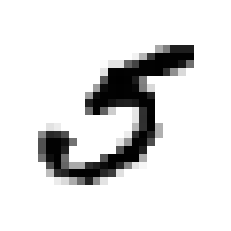

In [6]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=plt.get_cmap("gray_r"),
           interpolation="nearest")
plt.axis("off")
plt.show()

其中的一个样本，看着像5，我们查看一下标签：

In [13]:
y[36000]

5

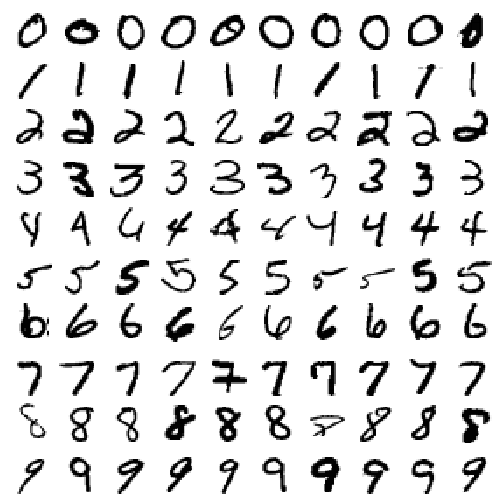

In [14]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.get_cmap("gray_r"), **options)
    plt.axis("off")

plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

以上是查看其中的一部分图像。

把数据集分为训练集和测试集，需要把图像乱序，否则训练效果不佳。

In [15]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

3.我们使用梯度下降算法，先把问题简化一下，测试两分类，也就是5和非5的情况。

In [17]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

4.测试一下效果。

In [18]:
sgd_clf.predict([some_digit])

array([ True])

能够正确分类。

5.我们交叉验证一下分类器。

In [19]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96225, 0.9645 , 0.94765])

准确率达到了96%，是不是我们的模型已经足够好了呢。

6.下面来测试一个最笨的分类器，看看它的效果。

In [20]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

这个最笨的分类器准确率也有90%，说明是样本分布的问题，因为绝大多数样本都是非5，所以最笨的分类器也有很好的表现。

使用准确率来衡量分类器会有很大的问题，特别是样本分布有偏差的数据集，比如一种分类比另一种分类要多很多时。

7.使用混淆矩阵来评估分类器。

In [24]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred[0:20]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True])

我们得到了训练集样本的预测值，然后和标签比较，产生混淆矩阵。

In [25]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53417,  1162],
       [ 1350,  4071]], dtype=int64)

53417表示真反例（TN）,也就是非5的数字分类正确。

1162表示假正例（FP）,也就是非5的数字被识别成了5。

1350表示假反例（FN）,也就是5的数字被分类成了非5。

4071表示真正例（TP）,也就是5的数字分类正确。

8.准确率和召回率。

准确率=TP/(TP+FP)，召回率=TP/(FN+TP)

In [26]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.7779476399770686

以上是准确率。

In [27]:
recall_score(y_train_5, y_train_pred)

0.7509684560044272

以上是召回率。

9.有些实例中要求准确率高，有些要求召回率高，两者不可兼得；下面我们画出召回率和准确率的曲线。

In [29]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [31]:
y_scores[0:10]

array([ -344482.72660078, -2207948.71399372,  -747234.78009357,
        -484767.20562804,  -468335.78059607,  -408939.5646945 ,
        -605512.48296772,  -259980.56489848,  -310147.38164882,
        -387143.33685258])

返回的是决策分数。

In [33]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

以上得到了阈值和召回率，准确率的关系值，每个阈值都对应不同的召回率和准确率。

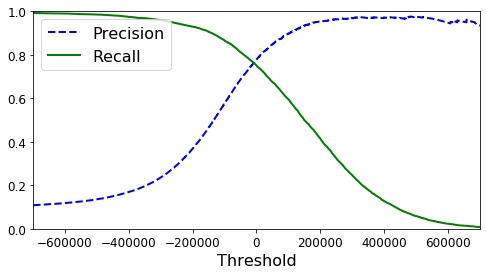

In [34]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()